# Pyomo Basics

&#169; University of Notre Dame. CBE 20258. Spring 2020.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

## Overview

So far, we have learned to numerically solve square systems of equations, i.e., systems with zero degrees of freedom. But as engineers, we often want to use extra degrees of freedom to improve one or more objective functions. For example, we may want to change the recycle flowrate in a chemical process to balance energy usage (operating cost) and equipment size (capital cost).

Here are two articles that give more examples of optimization problems.

1. [Water Reuse Networks](https://www.sciencedirect.com/science/article/pii/S0098135404001565?casa_token=vO761nMJ9CwAAAAA:rThzdy07Zgoi9Y5Bd7soAJnwbILWHQZ2zzN4rsvujeWjEyyfew_rXVgbAuuYdTGrDKbj9-JbLgQ)
2. [Training Machine Learning Models](https://aiche.onlinelibrary.wiley.com/doi/abs/10.1002/prs.12103?casa_token=t7j78jzYFyMAAAAA:MDnYJdgSrlNsniudvbMQEdo8gqBLOnYMK06yCgyMsVnX3Fm8BLo2G8b3RU_gZyFFg4bUrFVwRYKrkBg)

Consider joining AIChE (American Institute of Chemical Engineers) for free as an undergraduate student:  https://www.aiche.org/community/students/student-membership

## Constrained Nonlinear Optimization: Canonical Form

Below is a nonlinear optimization problem in canonical form.

$$\begin{align}\min \quad & f(x) \\
\mathrm{s.t.} \quad & g(x) \geq 0 \\
 & h(x) = 0 \\
 & x \in \mathbb{R}^{n}\end{align}$$

Note: Some textbooks alternately write $g(x) \leq 0$ as canonical form.

Let's walk through each part.
* $x$ is a $1 \times n$ vector, known as the **decision variable**. We will stick with real numbers, i.e., $x \in \mathbb{R}^n$. Temperatures, pressures, flowrates, and compositions are typical decision variables in chemical engineering problems.
* $f(x)$ is a scalar-valued function, known as the **objective function**. This is the quantity we want to minimize or maximize. Energy usage, efficiency, cost, and envirnomental impact are typical objective functions in chemical engineering problems.
* $g(x)$ is a vector-valued function, known as the **inequality constraint**. The most common inequality constraints in chemical engineering problems are **bounds** such as moles fractions are between 0 and 1, temperature must not exceed 1000K for safety reasons, etc. Sometimes we use inequality constraints to model process equipment (e.g., cannot destroy entropy).
* $h(x)$ is a vector-valued function, known as the **equality constraint**. Equality constraints are equations such as mass and energy balances, thermodynamic equations of state, and other engineering correlations you learned about in other chemical engineering classes.

## Pyomo in an Example

Let's start with a purely mathematical example:

$$\begin{align*} \min_{x} \quad & x_1^2 + 2 x_2^2 - x_3 \\
\mathrm{s.t.} \quad & x_1 + x_2 = 1 \\
& x_1 + 2 x_2 - x_3 = 5 \\
& -10 \leq x_1, x_2, x_3 \leq 10 
\end{align*} $$

We want to solve the constrained optimization problem numerically.

``scipy.optimize`` supports several different numerical methods for optimization. Based on past experiences, many of these implementations are not reliable. The solvers also do not use a standard interface.

Instead, we will learn how to use Pyomo, an open-source optimization modeling environment for Python. Prof. Dowling uses Pyomo in his research. Moreover, Prof. Kantor will ask you to use Pyomo extensively next year in Process Controls.

### Declare Model

We start by declaring the model in Pyomo.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Fill in the missing constraint.
</div>

In [2]:
# Create instance of concrete Pyomo model.
# concrete means all of the sets and model data are specified at the time of model construction.
# In this class, you'll use a concrete model.
m = ConcreteModel()

## Declare variables with initial values with bounds
m.x1 = Var(initialize=1, bounds=(-10, 10))
m.x2 = Var(initialize=1, bounds=(-10, 10))
m.x3 = Var(initialize=1, bounds=(-10, 10))

## Declare objective
m.OBJ = Objective(expr=m.x1**2 + 2*m.x2**2 - m.x3, sense = minimize)

## Declare equality constraints
m.h1 = Constraint(expr= m.x1 + m.x2 == 1)

### BEGIN SOLUTION
m.h2 = Constraint(expr= m.x1 + 2*m.x2 - m.x3 == 5)
### END SOLUTION

## Display model
m.pprint()

3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x3 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals

1 Objective Declarations
    OBJ : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x1**2 + 2*x2**2 - x3

2 Constraint Declarations
    h1 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :   1.0 : x1 + x2 :   1.0 :   True
    h2 : Size=1, Index=None, Active=True
        Key  : Lower : Body           : Upper : Active
        None :   5.0 : x1 + 2*x2 - x3 :   5.0 :   True

6 Declarations: x1 x2 x3 OBJ h1 h2


We see a lot of information printed on the screen. For example, we see:

```
3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
```

This shows the lower bound, initial value, and upper bound for the variable named `x1`.

### Solve Numerically

We can now solve the optimization problem. We will use the solver `Ipopt`.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [11]:
## Specify IPOPT as solver
solver = SolverFactory('ipopt')

## Solve the model
results = solver.solve(m, tee = True) # tee = True prints the output of the solver

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0


Now let's inspect the solution. We'll use the function `value()` to extract the numeric value from the Pyomo variable object.

In [4]:
## Return the solution
print("x1 = ",value(m.x1))
print("x2 = ",value(m.x2))
print("x3 = ",value(m.x3))
print("\n")

x1 =  0.4999999999666826
x2 =  0.5000000000333175
x3 =  -3.499999999966682




### Visualize Solution

Is our answer correct?

We can solve this optimization problem with guess and check. If we guess $x_3$, we can then solve the constraints for $x_1$ and $x_2$. We can then evaluate the objective. Let's see the graphical solution to our optimization problem.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: First write the constraints as a linear system of equations. Then complete the function below to solve the following constraints. We will treat $x_1$ and $x_2$ as the unknown variables. We will treat $x_3$ as a known constant (parameter).</div>

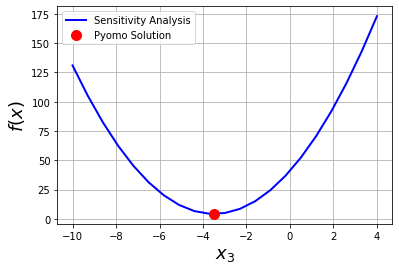

In [5]:
def constraints(x3):
    ''' Solve the linear constraints
    
    Args:
        x3: Value for the decision variable x3
        
    Returns:
        x1 and x2: Values calculated from the constraints
    '''
    # create arrays for A and b to solve the linear system of equations
    ### BEGIN HIDDEN SOLUTION
    A = np.array([[1, 1],[1, 2]])
    b = np.array([1, 5+x3])
    ### END HIDDEN SOLUTION
    
    # solve the linear system
    z = np.linalg.solve(A,b)
    x1 = z[0]
    x2 = z[1]
    return x1, x2

# Define a lambda function to plot the objective
objective = lambda x1, x2, x3: x1**2 + 2*x2**2 - x3

# Guess many values of x3.
x3_guesses = np.linspace(-10,4,21)
obj = []
for x3 in x3_guesses:
    # Solve the constraints to determine x1 and x2
    x1, x2 = constraints(x3)
    # Calculate the store the objective function value
    obj.append(objective(x1,x2,x3))

# Plot the objective function value versus x3
plt.plot(x3_guesses, obj,color='blue',linewidth=2,label="Sensitivity Analysis")
plt.xlabel("$x_3$",fontsize=18)
plt.ylabel("$f(x)$",fontsize=18)
x3_sln = value(m.x3)
obj_sln = value(m.OBJ)
plt.plot(x3_sln, obj_sln,marker='o',color='red',markersize=10,label="Pyomo Solution",linestyle='')
plt.legend()
plt.grid(True)
plt.show()

## Example: Planting Cherry Trees

Suppose we have \\$20,000 to invest in planting cherry trees.  We can plant a mix of sour (dessert) cherries and sweet cherries (the ones you like to eat).  The sour cherry trees cost \\$20 each, and the sweet cherry trees cost \\$10 each.  The sweet cherries, however, can be sold for \\$100 per tree per year when mature if fully pollinated, while the sour cherries can be sold for only \\$25 per tree when mature.  Finally, the yield per tree of the sweet cherry trees depends on their proximity to the sour cherry trees, since they are not self-pollinating.  If the number of sour trees is given by $x_1$ and the number of sweet trees is $x_2$, we shall take the yield (the fraction of the fully pollinated yield) of the sweet trees to be $x_1$ / ($x_2$ + $x_1$).

### Step 1: Develop Mathematical Model, Convert to Canonical Form

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Write the optimization problem in canonical form on paper. Use this to solve step 2.
</div>

### Step 2: Solve in Python

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Finish the Pyomo model below.
</div>

In [6]:
## Problem Specifications

# Concrete model
m = ConcreteModel()

# Budget
b = 20000;

# Cost per sour tree
c1 = 20;

# Cost per sweet tree
c2 = 10;

# Revenue per fully polinated sour tree
p1 = 25;

# Revenue per fully polinated sweet tree
p2 = 100

## Define variables
m.x1 = Var(initialize=1, bounds=(0,None)) # sour cherries
### BEGIN SOLUTION
m.x2 = Var(initialize=1, bounds=(0,None)) # sweet cherries
### END SOLUTION

## Objective function
### BEGIN SOLUTION
m.obj = Objective(expr=p1*m.x1 + p2*m.x2*m.x1/(m.x1 + m.x2), sense = maximize)
### END SOLUTION

## Constraint
### BEGIN SOLUTION
m.con = Constraint(expr=b - c1*m.x1 - c2*m.x2 >= 0)
### END SOLUTION

## Print the model
m.pprint()

2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :     1 :  None : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :     1 :  None : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 25*x1 + 100*x2*x1/(x1 + x2)

1 Constraint Declarations
    con : Size=1, Index=None, Active=True
        Key  : Lower : Body                  : Upper : Active
        None :   0.0 : 20000 - 20*x1 - 10*x2 :  +Inf :   True

4 Declarations: x1 x2 obj con


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Solve the Pyomo model.
</div>

In [7]:
## Solve the model
# Recall, we already defined solver
results = solver.solve(m, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0


In [12]:
# Print the solution
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  666.6666733332888 sour cherry trees
Plant  666.666673333322 sweet cherry trees
Giving revenue of 50000.00049999749 dollars


### Interpret Answer

Can we plant 2/3 of a cherry tree?

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Determine the best way to round the solution.
</div>

In [13]:
## Let's plant 667 sour trees and resolve
m.x1.fix(667)
results = solver.solve(m, tee = False)
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  667 sour cherry trees
Plant  666.0000066598999 sweet cherry trees
Giving revenue of 49999.981412058725 dollars


In [14]:
## What if we instead plant 666 sour trees?
m.x1.fix(666)
results = solver.solve(m, tee = False)
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  666 sour cherry trees
Plant  668.0000066798995 sweet cherry trees
Giving revenue of 49999.92520397838 dollars


Which method produces a larger revenue?  Is there a significant difference?